# Lognormal test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering the quarter of the sky with $|\cos\theta|<1/2$ and $\pi/2 < \phi < 3\pi/2$.

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt
#
sys.path.append('../sht')
from sht import DirectSHT

In [2]:
# Get a random number generator.
rng = np.random.default_rng()

In [3]:
# Set up an sht instance.  We will set
# Nx to be quite large, so that we are
# confident in our interpolation.
Nl   = 2**9
Nx   = 4*Nl+1
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
print("Direct SHT has Nl=",Nl,", Nx=",Nx," and xmax=",xmax)

Direct SHT has Nl= 512 , Nx= 2049  and xmax= 0.625


In [4]:
# Set up a "binning matrix" that combines adjacent
# ells into coarser bins.
NperBin = 2**4
bins    = np.zeros( (Nl//NperBin,Nl) )
for i in range(0,Nl,NperBin):
    bins[i//NperBin,i:i+NperBin] = 1/float(NperBin)
# Also set it such that we drop the ell=0 bin
# when we do our average(s).
bins[0,0] = 0.0

In [5]:
# Code to generate a lognormal catalog of approximately Npnt
# points, assuming a Gaussian angular power spectrum, clg.
def lognormal_catalog(Npnt,clg,nside=256):
    """Returns (theta,phi,wt) for about Npnt points.  This
    should be run with Npnt<<Npix=12*nside^2."""
    gmap = hp.synfast(clg,nside,alm=False,pol=False)
    print("gmap in range ({:e},{:e})".format(np.min(gmap),np.max(gmap)))
    emap = np.exp(gmap)
    emap*= Npnt/np.sum(emap)
    print("emap in range ({:e},{:e})".format(np.min(emap),np.max(emap)))
    ngal = rng.poisson(lam=emap,size=emap.size)
    ipix = np.nonzero(ngal>0)[0]
    thta,phi = hp.pix2ang(nside,ipix,lonlat=False)
    wt   = np.ones_like(thta)
    # Now very slightly perturb the positions away from
    # the pixel centers.
    blur = np.sqrt( hp.pixelfunc.nside2pixarea(nside) )
    thta+= blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    phi += blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    return( (thta,phi,wt) )

In [6]:
# Generate points -- start with full sky
ell  = np.arange(1000)
ell0 = 10.
clg  = 0.001 * (ell0/(ell+ell0))**(1.1)
nside= 2048
npnt = 4 * 100000
thetas,phis,wts = lognormal_catalog(npnt,clg,nside)
# and cut to the "observed region"
cost = np.cos(thetas)
ww   = np.nonzero( (np.abs(cost)<0.5)&\
                   (phis>np.pi/2)&(phis<3*np.pi/2) )[0]
thetas,phis,wts = thetas[ww],phis[ww],wts[ww]
#
npnt = len(thetas)
nbar = npnt / (4*np.pi) # Objects/sr.
#
print("Kept {:d} objects in cut.".format(len(wts)))

gmap in range (-4.989624e+00,5.331640e+00)
emap in range (3.212869e-05,9.757999e-01)
Kept 96730 objects in cut.


In [7]:
# Generate a random catalog.
nrand = 10*len(thetas)
trand = np.arccos( rng.uniform(low=-0.5,high=0.5,size=nrand) )
prand = rng.uniform(low=np.pi/2,high=3*np.pi/2,size=nrand)
wrand = np.ones_like(trand) * float(npnt)/float(trand.size)

In [8]:
# If we wanted to put more structure in the mask
# here we could "cut out" various pieces of the
# disk, vetoing both data and random points.

## Harmonic analysis.

Let's compute the $a_{\ell m}$ by direct summation, then compute the binned, pseudo-power spectrum and finally look at the sources on a map.

In a notebook this is kind of slow, but not unmanageable (around a minute).

In [9]:
halm = sht(thetas,phis,wts)
hcl  = hp.alm2cl(halm)
# Bin them up.
ell = np.dot(bins,np.arange(Nl))
hcl = np.dot(bins,hcl)

In [10]:
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)
hrcl = np.dot(bins,hrcl)
# and the difference of data and randoms:
hdif = hp.alm2cl(halm-hran)
hdif = np.dot(bins,hdif)

Text(0, 0.5, 'Healpy $C_\\ell$')

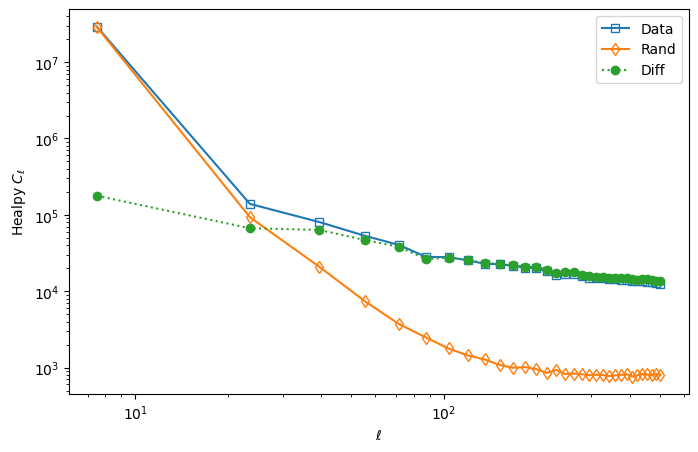

In [11]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(ell, hcl,'s-',color='C0',mfc='None',label='Data')
ax.plot(ell,hrcl,'d-',color='C1',mfc='None',label='Rand')
ax.plot(ell,hdif,'o:',color='C2',label='Diff')
#
ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'Healpy $C_\ell$')

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [12]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

0.0 180.0 -180.0 180.0


dmap.sum= 1513395746.7615101
rmap.sum= 1513395746.7629013


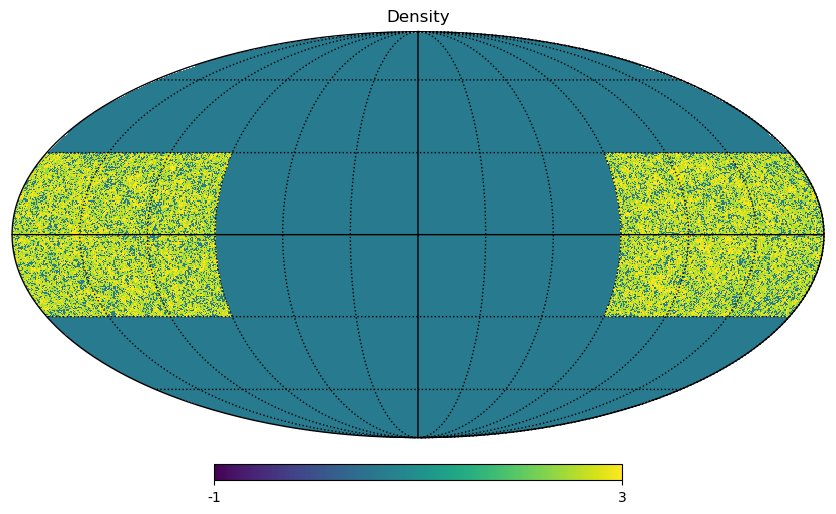

In [13]:
# Show an example at some nside.
# Eventually want to plot in grey the masked region
# and make it look pretty.
nside= 128
dmap = make_map(thetas,phis,wts  ,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
dmap[rmap<=0]=0.0
dmap = dmap/(rmap+1e-30)
ma   = hp.pixelfunc.ma(dmap)
hp.mollview(dmap,min=-1,max=3,norm='hist',title='Density')
hp.graticule()
plt.show()

Now compare the power spectra as a function of the map Nside.

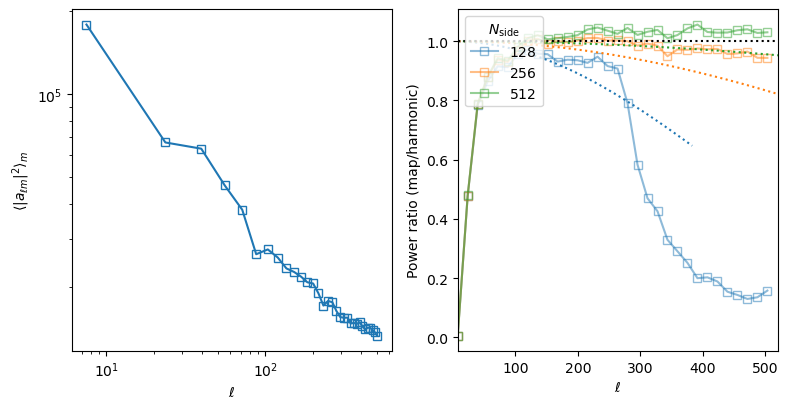

In [14]:
fig,ax = plt.subplots(1,2,sharey=False,figsize=(8,4.2))
#
ax[0].loglog(ell,hdif,'s-',mfc='None')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\langle |a_{\ell m}|^2\rangle_m$')
#
icol= 0
for nside in [128,256,512]:
    dmap = make_map(thetas,phis,wts  ,nside)
    rmap = make_map(trand,prand,wrand,nside)
    #dmap[rmap<=0]=0.0
    # Need to divide by randoms etc.
    #mcl  = hp.sphtfunc.anafast(dmap/(rmap+1e-30)-1,alm=False,\
    #                           lmax=sht.Nell-1,pol=False)
    mcl  = hp.sphtfunc.anafast(dmap-rmap,alm=False,\
                               lmax=sht.Nell-1,pol=False)
    # Need to normalize this appropriately.
    # mcl *= nbar**2
    # Now form the ratio with the direct harmonic answer.
    ratio= np.dot(bins,mcl)/hcl
    pixwn= hp.pixwin(nside)
    #
    ax[1].plot(ell,ratio,'s-',color='C'+str(icol),alpha=0.5,\
               mfc='None',label='${:4d}$'.format(nside))
    ax[1].plot(np.arange(pixwn.size),pixwn,ls=':',color='C'+str(icol))
    icol = (icol+1)%10
ax[1].axhline(1.0,ls=':',color='k')
ax[1].set_xlim(8.0,520)
ax[1].set_ylabel(r'Power ratio (map/harmonic)')
ax[1].legend(title=r'$N_{\rm side}$',loc=2)
#ax[1].set_ylim(0.9,1.1)
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$\ell$')
#
plt.tight_layout()
#plt.savefig('lognormal.pdf')

# The End